In [654]:
import numpy as np
import pandas as pd
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb
import itertools
import networkx as nx
import matplotlib.pyplot as plt

In [655]:
# Create the combined Bayesian NetworkLabelizedVariable
bn = gum.BayesNet("CombinedDepressionModel")

# -----------------------------------------
# Sociodemographic Branch
# -----------------------------------------

# Independent nodes
age = bn.add(gum.LabelizedVariable("Age", "Age category", ["15-34", "35-54", "55-74"]))
edu = bn.add(gum.LabelizedVariable("Education", "Education Level", ["Low", "Medium", "High"]))
inc = bn.add(gum.LabelizedVariable("Income", "Income Level", ["Unemployed", "Employed"]))
bn.addArc(age, inc)
bn.addArc(edu, inc)

# Aggregated SocioStatus
socio = bn.add(gum.LabelizedVariable("SocioStatus", "Overall sociodemographic status", ["Low", "High"]))
bn.addArc(edu, socio)
bn.addArc(inc, socio)

# -----------------------------------------
# Physical Health Branch
# -----------------------------------------
physicalActivity = bn.add(gum.LabelizedVariable("Physical Activity", "Physical Activity Level", ["Inactive", "Moderate", "Active"]))
obesity = bn.add(gum.LabelizedVariable("Obesity", "Obesity Status", ["Obese", "Not Obese"]))

# Aggregated PhysicalHealth
physattri = bn.add(gum.LabelizedVariable("Physical Attribute", "Overall Physical Attribute", ["Poor", "Good"]))
bn.addArc(physicalActivity, physattri)
bn.addArc(obesity, physattri)

# -----------------------------------------
# Additional Independent Nodes
# -----------------------------------------

# Define a non-binary variable with three states representing genetic predisposition:
genetic = bn.add(gum.LabelizedVariable("GeneticPredisposition", "Genetic Predisposition", ["Absent", "Present"]))
bn.cpt(genetic).fillWith([0.80, 0.20])


adverse = bn.add(gum.LabelizedVariable("AdverseChildhood", "Adverse Childhood Experiences", ["Absent", "Present"]))
bn.cpt(adverse).fillWith([0.95, 0.05])  # 70% report no ACE, 30% do

# -----------------------------------------
# Outcome Node: Depression 
# -----------------------------------------

depress = bn.add(gum.LabelizedVariable("Depression", "Depression Status", ["No", "Yes"]))
bn.addArc(socio, depress)
bn.addArc(physattri, depress)
bn.addArc(genetic, depress)
bn.addArc(adverse, depress)


In [656]:
df_edu = pd.read_csv('Onderwijs.csv', delimiter=';', decimal=',')
df_age = pd.read_csv('Leeftijd.csv', delimiter=';', decimal=',')

In [657]:
# Group 1: Basic and lower secondary education (rows 0 and 1)
group1_total_edu = df_edu.iloc[0:2]['Bevolking  (x 1000)'].sum()

# Group 2: Upper secondary education (row 2)
group2_total_edu = df_edu.iloc[2:3]['Bevolking  (x 1000)'].sum()

# Group 3: Higher education (rows 3 and 4)
group3_total_edu = df_edu.iloc[3:5]['Bevolking  (x 1000)'].sum()

# Calculate the overall total population
total_population_edu = group1_total_edu + group2_total_edu + group3_total_edu

# Convert each group's total into a percentage of the overall population
perc_group1_edu = group1_total_edu / total_population_edu
perc_group2_edu = group2_total_edu / total_population_edu
perc_group3_edu = group3_total_edu / total_population_edu

# Create the percentage list (rounded to 2 decimals)
percentage_edu = [perc_group1_edu, perc_group2_edu, perc_group3_edu]


In [658]:
# Aggregate population counts by the three broader age groups:
# Group 1: "15 tot 35 jaar" (rows 0 to 3)
group1_total_age = df_age.iloc[0:4]['Bevolking (aantal)'].sum()

# Group 2: "35 tot 55 jaar" (rows 4 to 7)
group2_total_age = df_age.iloc[4:8]['Bevolking (aantal)'].sum()

# Group 3: "55 tot 75 jaar" (rows 8 to 11)
group3_total_age = df_age.iloc[8:12]['Bevolking (aantal)'].sum()

# Calculate the overall total population
total_population_age = group1_total_age + group2_total_age + group3_total_age

# Convert each group's total into a percentage of the overall population
perc_group1_age = group1_total_age / total_population_age
perc_group2_age = group2_total_age / total_population_age
perc_group3_age = group3_total_age / total_population_age

# Create the percentage list (rounded to 2 decimals)
percentage_age = [perc_group1_age, perc_group2_age, perc_group3_age]

In [659]:
# -----------------------------------------
# Setting Up the CPTs for the Other Nodes
# -----------------------------------------
# Sociodemographic branch
bn.cpt(edu).fillWith(percentage_edu)
bn.cpt(age).fillWith(percentage_age) # gehaald van CBS


(pyAgrum.Potential<double>@00000226A37B9160) 
  Age                        |
15-34    |35-54    |55-74    |
---------|---------|---------|
 0.3315  | 0.3429  | 0.3255  |

In [660]:
df_inc = pd.read_csv('Income.csv', delimiter=';', decimal=',')
df_inc.rename(columns={
    'Beroeps- en niet-beroepsbev. met inkomen/Beroeps- en niet-beroepsbev. met inkomen (x 1 000)': 'Income'
}, inplace=True)


In [661]:
df_inc_edu_emp = df_inc.iloc[0:3] 
df_inc_edu_unemp = df_inc.iloc[9:12]
df_inc_age_emp = df_inc.iloc[3:9]
df_inc_age_unemp = df_inc.iloc[12:18]


In [662]:
# Calculate sum of Income for the employed slice (rows 0 to 2)
sum_income_emp = df_inc_edu_emp['Income'].sum()

# Calculate sum of Income for the unemployed slice (rows 9 to 11)
sum_income_unemp = df_inc_edu_unemp['Income'].sum()

# If you would like a total sum across both groups, simply add them:
total_income = sum_income_emp + sum_income_unemp
percentage_emp = (sum_income_emp / total_income) * 100
percentage_unemp = (sum_income_unemp / total_income) * 100

print("Percentage of Income (Employed): {:.2f}%".format(percentage_emp))
print("Percentage of Income (Unemployed): {:.2f}%".format(percentage_unemp))

Percentage of Income (Employed): 96.25%
Percentage of Income (Unemployed): 3.75%


In [663]:
inc_edu_emp = []
inc_edu_unemp = []
for i in range(len(df_inc_edu_emp)):
    temp_edu_emp = df_inc_edu_emp["Income"][i]/(df_inc_edu_emp["Income"][i]+df_inc_edu_unemp["Income"][i+9])
    temp_edu_unemp = df_inc_edu_unemp["Income"][i+9]/(df_inc_edu_emp["Income"][i]+df_inc_edu_unemp["Income"][i+9])
    inc_edu_emp.append(temp_edu_emp)
    inc_edu_unemp.append(temp_edu_unemp)
inc_edu = [inc_edu_emp, inc_edu_unemp]

In [664]:
inc_age_emp = []
inc_age_unemp = []
for i in range(len(df_inc_age_emp)):
    temp_age_emp = df_inc_age_emp["Income"][i+3]/(df_inc_age_emp["Income"][i+3]+df_inc_age_unemp["Income"][i+12])
    temp_age_unemp = df_inc_age_unemp["Income"][i+12]/(df_inc_age_emp["Income"][i+3]+df_inc_age_unemp["Income"][i+12])
    inc_age_emp.append(temp_age_emp)
    inc_age_unemp.append(temp_age_unemp)
inc_age = [inc_age_emp, inc_age_unemp]

In [665]:
# For Income (now conditioned on both Age and Education), we specify 9 rows.
cpt_inc = bn.cpt(inc)
# For Young individuals (Age = 0):
cpt_inc[{'Age': 0, 'Education': 0}] = [0.90, 0.01]  # Lowest education
cpt_inc[{'Age': 0, 'Education': 1}] = [0.80, 0.05]
cpt_inc[{'Age': 0, 'Education': 2}] = [0.70, 0.10]

# For Middle-aged individuals (Age = 1):
cpt_inc[{'Age': 1, 'Education': 0}] = [0.60, 0.15]
cpt_inc[{'Age': 1, 'Education': 1}] = [0.40, 0.25]
cpt_inc[{'Age': 1, 'Education': 2}] = [0.30, 0.30]

# For Old individuals (Age = 2):
cpt_inc[{'Age': 2, 'Education': 0}] = [0.70, 0.10]
cpt_inc[{'Age': 2, 'Education': 1}] = [0.15, 0.60]
cpt_inc[{'Age': 2, 'Education': 2}] = [0.10, 0.70]

In [666]:
# Assume that 'bn' is your Bayesian network and 'socio' is the aggregated SocioStatus node.
# The CPT for SocioStatus has 3 outcomes (e.g., 0 = High,  1 = Low).
cpt_socio = bn.cpt(socio)

# --- For Age = 0 (Young) ---
cpt_socio[{'Education': 0, 'Income': 0}] = [0.05, 0.95]  
cpt_socio[{'Education': 0, 'Income': 1}] = [0.1, 0.90]

# --- For Age = 1 (Middle-aged) ---
cpt_socio[{'Education': 1, 'Income': 0}] = [0.3, 0.7] 
cpt_socio[{'Education': 1, 'Income': 1}] = [0.5, 0.5]

# --- For Age = 2 (Old) ---
cpt_socio[{'Education': 2, 'Income': 0}] = [0.6, 0.4] 
cpt_socio[{'Education': 2, 'Income': 1}] = [0.8, 0.2]


In [667]:
# Physical Health branch
bn.cpt(physicalActivity).fillWith([0.3, 0.4, 0.3])
bn.cpt(obesity).fillWith([0.4, 0.6])

(pyAgrum.Potential<double>@00000226A37BA4A0) 
  Obesity          |
Obese    |Not Obese|
---------|---------|
 0.4000  | 0.6000  |

In [668]:
# Retrieve the CPT for the Physical Attribute node (which now has parents: PhysicalActivity and Obesity)
cpt_physattri = bn.cpt(physattri)

# For PhysicalActivity = Active (index 0) and Obesity = Not Obese (index 0)
cpt_physattri[{'Physical Activity': 0, 'Obesity': 0}] = [0.95, 0.05]
# For PhysicalActivity = Active (index 0) and Obesity = Obese (index 1)
cpt_physattri[{'Physical Activity': 0, 'Obesity': 1}] = [0.6, 0.4]

# For PhysicalActivity = Moderate (index 1) and Obesity = Not Obese (index 0)
cpt_physattri[{'Physical Activity': 1, 'Obesity': 0}] = [0.8, 0.2]
# For PhysicalActivity = Moderate (index 1) and Obesity = Obese (index 1)
cpt_physattri[{'Physical Activity': 1, 'Obesity': 1}] = [0.5, 0.5]

# For PhysicalActivity = Inactive (index 2) and Obesity = Not Obese (index 0)
cpt_physattri[{'Physical Activity': 2, 'Obesity': 0}] = [0.4, 0.6]
# For PhysicalActivity = Inactive (index 2) and Obesity = Obese (index 1)
cpt_physattri[{'Physical Activity': 2, 'Obesity': 1}] = [0.0, 1.0]


In [669]:
# --- Define risk parameters ---
# These values represent the triggering chances for each contributing factor
ss_params = {0: 0.01, 1: 0.05}     # For SocioStatus: 0 = High, 1 = Medium, 2 = Low
ph_params = {0: 0.0, 1: 0.02}      # For Physical Attribute: 0 = Good, 1 = Moderate, 2 = Poor
ace_params = {0: 0.01, 1: 0.2}              # For ACE: 0 = Absent, 1 = Present
gp_multiplier = {0: 1.0, 1: 2}         
leak = 0.01                             # A small baseline risk

# --- Retrieve and fill the CPT for Depression ---
cpt_depress = bn.cpt(depress)
cpt_values = []  # will accumulate a flat list of 72 numbers

# For each combination of parent states:
for ace_state, gp_state, ph, ss in itertools.product(range(2), range(2), range(2), range(2)):
    # Compute the baseline probability without Genetic:
    prod_failure = (1 - ss_params[ss]) * (1 - ph_params[ph]) * (1 - ace_params[ace_state]) * (1 - leak)
    p_baseline = 1 - prod_failure  # noisy-OR probability from these factors

    # genetic alone will not generate risk.
    if gp_state == 1:
        p_dep = min(1.0, p_baseline * gp_multiplier[1])
    else:
        p_dep = p_baseline

    # For a binary outcome, the CPT row is: [P(No Depression), P(Depression)]
    cpt_values.extend([1 - p_dep, p_dep])

# Use fillWith with a flat list of 72 values
cpt_depress.fillWith(cpt_values)

(pyAgrum.Potential<double>@00000226A37BB0E0) 
                           ||  Depression       |
SocioS|Physic|Geneti|Advers||No       |Yes      |
------|------|------|------||---------|---------|
Low   |Poor  |Absent|Absent|| 0.9703  | 0.0297  |
High  |Poor  |Absent|Absent|| 0.9311  | 0.0689  |
Low   |Good  |Absent|Absent|| 0.9509  | 0.0491  |
High  |Good  |Absent|Absent|| 0.9125  | 0.0875  |
Low   |Poor  |Presen|Absent|| 0.9406  | 0.0594  |
High  |Poor  |Presen|Absent|| 0.8622  | 0.1378  |
[...4 more line(s) ...]
Low   |Good  |Absent|Presen|| 0.7684  | 0.2316  |
High  |Good  |Absent|Presen|| 0.7374  | 0.2626  |
Low   |Poor  |Presen|Presen|| 0.5682  | 0.4318  |
High  |Poor  |Presen|Presen|| 0.5048  | 0.4952  |
Low   |Good  |Presen|Presen|| 0.5368  | 0.4632  |
High  |Good  |Presen|Presen|| 0.4747  | 0.5253  |

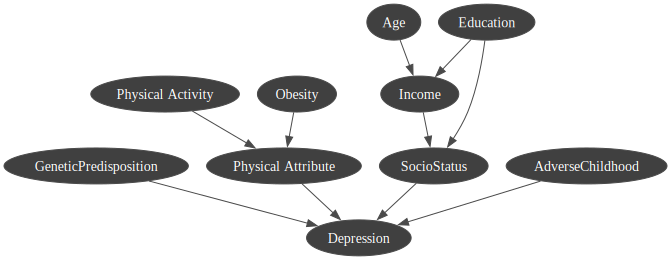

In [670]:
gnb.show(bn, size="11")  # Increase graphical scaling

In [671]:
# Iterate over all nodes in the BN and show their CPTs:
for node in bn.nodes():
    var_name = bn.variable(node).name()
    print(f"Statistics for {var_name}:")
    gnb.showPotential(bn.cpt(node))

Statistics for Age:


Statistics for Education:


Statistics for Income:


Statistics for SocioStatus:


Statistics for Physical Activity:


Statistics for Obesity:


Statistics for Physical Attribute:


Statistics for GeneticPredisposition:


Statistics for AdverseChildhood:


Statistics for Depression:


In [ ]:
ie = gum.LazyPropagation(bn)
ie.setEvidence({'Age': [0.6, 0.3, 0.1]})
ie.setEvidence({'Obesity': [0.6, 0.4]})
gnb.showInference(bn)